# Re-gridding output

This notebook how we can regrid the ACCESS-OM2 output onto a different grid. In particular, we demonstrate how we can 
take model output from all three ACCESS-OM2 resolutions and regrid them onto a 1 degree normal Mercator longitude-latitude grid.

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI/gadi (or your own up-to-date cookbook installation).
    
**Note:** Computing the interpolation weights via the `xesmf` package might not work on `conda/analysis3-20.10` (or later) due to different compilers used. A solution is to create your own environment and install `xesmf` there.

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xarray as xr
import xesmf

Load a `dask` client.

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:37981 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 48 Memory: 202.48 GB


And also create a `session` for `cosima-cookbook`. Here we use a `session` with the default database.

In [3]:
session = cc.database.create_session()

Next we load the grid parameters for each resolution. We use `.reset_coords()` and `.drop()` on some grids to bring them in the format that the `xesmf` package needs.

In [4]:
grid1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
grid1 = grid1.reset_coords({'geolat_t', 'geolon_t', 'geolat_c', 'geolon_c'})
grid1 = grid1.drop({'xt_ocean', 'yt_ocean', 'xu_ocean', 'yu_ocean'})

grid025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')
grid025 = grid025.reset_coords({'geolat_t', 'geolon_t', 'geolat_c', 'geolon_c'})
grid025 = grid025.drop({'xt_ocean', 'yt_ocean', 'xu_ocean', 'yu_ocean'})

grid010 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

## Load raw data

We load some raw data from ACCESS-OM2 models. In particular, we load here the 2 years of monthly sea-surface height. We make sure to assign the correct tripolar coordinates as `coords`. Since sea-surface height is lives on `t`-cells, we add `geolon_t` and `geolat_t`.

In [5]:
expt = '1deg_jra55v13_iaf_spinup1_B1'
ssh_1 = cc.querying.getvar(expt, 'sea_level', session, frequency='1 monthly',
                           start_time='2000-01-01', end_time='2001-12-31')
ssh_1 = ssh_1.sel(time=slice('2000', '2001'))
ssh_1 = ssh_1.assign_coords({'geolat_t': grid1.geolat_t, 'geolon_t': grid1.geolon_t})
ssh_1 = ssh_1.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                      'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_1 = ssh_1.chunk(chunks='auto')
ssh_1

<xarray.DataArray 'sea_level' (time: 24, y: 300, x: 360)>
dask.array<rechunk-merge, shape=(24, 300, 360), dtype=float32, chunksize=(24, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
  * y          (y) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time       (time) object 2000-01-16 12:00:00 ... 2001-12-16 12:00:00
    latitude   (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid

In [6]:
expt = '025deg_jra55v13_iaf_gmredi6'
ssh_025 = cc.querying.getvar(expt, variable='sea_level', session=session, frequency='1 monthly',
                             start_time='2000-01-01', end_time='2001-12-31')
ssh_025 = ssh_025.sel(time=slice('2000', '2001'))
ssh_025 = ssh_025.assign_coords({'geolat_t': grid025.geolat_t, 'geolon_t': grid025.geolon_t})
ssh_025 = ssh_025.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                          'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_025 = ssh_025.chunk(chunks='auto')
ssh_025

<xarray.DataArray 'sea_level' (time: 24, y: 1080, x: 1440)>
dask.array<rechunk-merge, shape=(24, 1080, 1440), dtype=float32, chunksize=(12, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * y          (y) float64 -81.08 -80.97 -80.87 -80.76 ... 89.74 89.84 89.95
  * time       (time) object 2000-01-14 12:00:00 ... 2001-12-14 12:00:00
    latitude   (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid

In [7]:
ssh_010 = cc.querying.getvar('01deg_jra55v140_iaf', variable='sea_level', session=session,
                             ncfile='ocean-2d-sea_level-1-monthly-mean-ym_%.nc',
                             start_time='2000-01-01', end_time='2001-12-31')
ssh_010 = ssh_010.sel(time=slice('2000', '2001'))
ssh_010 = ssh_010.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
ssh_010 = ssh_010.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                          'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_010 = ssh_010.chunk(chunks='auto')
ssh_010

<xarray.DataArray 'sea_level' (time: 24, y: 2700, x: 3600)>
dask.array<rechunk-merge, shape=(24, 2700, 3600), dtype=float32, chunksize=(4, 2160, 2880), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * y          (y) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * time       (time) object 2000-01-16 12:00:00 ... 2001-12-16 12:00:00
    latitude   (y, x) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid

## Regrid using `xesmf`

We regrid all output onto a regular lat-lon grid with 1 degree lateral resolution. First we construct the `dataset` with the coordinates that we want to regrid onto.

In [8]:
ds_out = xesmf.util.grid_global(1, 1)
ds_out = ds_out.drop({'lon_b', 'lat_b'})

# let's shift our longitude grid so that it spans [-280, 80] instead [-180, 180]
# this is just for plotting purposes so that the seam is in the Indian Ocean
# rather than in the middle of the Pacific Ocean
ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})

ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
ds_out

<xarray.Dataset>
Dimensions:    (x: 360, y: 180)
Coordinates:
    longitude  (y, x) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    latitude   (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: x, y
Data variables:
    *empty*

Then we construct the three regridders for the three different resolutions using `xesmf.Regridder()`. The `xesmf.Regridder()` function takes as input two datasets, one that includes the original grid and one that includes the grids we need to regrid on. (Type `?xesmf.Regridder` for the function's docstring.) The coordinates' names have to follow CF-convetions and this is why we have renamed, e.g., `geolon_t` to `longitude`. We also make sure to drop the 1D coords `x` and `y` to **force** the regridder to use the 2D arrays `longitude` and `latitude`.

(The `regridder_010degACCESSOM2_1deg` below should take ~3-4 minutes to compute.)

In [9]:
ds_in_1deg = ssh_1.drop({'x', 'y'}).to_dataset()

regridder_1degACCESSOM2_1deg = xesmf.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True,
                                               filename="bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc")
regridder_1degACCESSOM2_1deg

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (300, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [10]:
ds_in_025deg = ssh_025.drop({'x', 'y'})

regridder_025degACCESSOM2_1deg = xesmf.Regridder(ds_in_025deg, ds_out, 'bilinear', periodic=True,
                                                 filename="bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc")
regridder_025degACCESSOM2_1deg

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [11]:
ds_in_010deg = ssh_010.drop({'x', 'y'})

regridder_010degACCESSOM2_1deg = xesmf.Regridder(ds_in_010deg, ds_out, 'bilinear', periodic=True,
                                                 filename="bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc")
regridder_010degACCESSOM2_1deg

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (2700, 3600) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

#### Note

For large grids (e.g., regridding from 0.10$^\circ$ grid to a 0.20 $^\circ$ grid), it might take a while to compute the re-grid weights. But, once you compute them once, you can construct a regridder using the already computed weights from a netCDF file by providing the `reuse_weights=True` argument, e.g.,

```python
regridder = xesmf.Regridder(ds_in, ds_out, 'bilinear', periodic=True, filename="weights_file.nc", reuse_weights=True)
```

## Let's regrid our output

Now we use the regridders we constructed above to regrid our output. Note that the dimensions we are applying the re-gridding can't be chunked, so we make sure we apply `.chunk({'x': None, 'y': None})` before giving the data arrays to the regridder. The `time` axis can be chunked --- for big datasets make sure that you rechunk `time` if needed so you don't end up with *huge* chunk sizes afte `.chunk({'x': None, 'y': None})` is applied.

Note also that for the regridded data arrays, we add back the longitude/latitude values on coords `x`/`y` respectively to make our lives easier with plotting later on.

In [12]:
ssh_1_regridded = regridder_1degACCESSOM2_1deg(ssh_1.chunk({'x': None, 'y': None}))
ssh_1_regridded = ssh_1_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_1_regridded = ssh_1_regridded.rename({'x': 'longitude', 'y': 'latitude'})

In [13]:
ssh_025_regridded = regridder_025degACCESSOM2_1deg(ssh_025.chunk({'x': None, 'y': None}))
ssh_025_regridded = ssh_025_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_025_regridded = ssh_025_regridded.rename({'x': 'longitude', 'y': 'latitude'})

In [14]:
ssh_010_regridded = regridder_010degACCESSOM2_1deg(ssh_010.chunk({'x': None, 'y': None}))
ssh_010_regridded = ssh_010_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_010_regridded = ssh_010_regridded.rename({'x': 'longitude', 'y': 'latitude', 'time': 2})

## Plotting time

Now we can plot the regridded fields, slicing as we like using `longitude` and `latitude` coordinates. Here's a comparisson of monthly-mean snapshots for sea-surface height in the North Pacific. Notice how things look "normal" north of 65$^\circ$N where the model's grid has the tripolar complications!

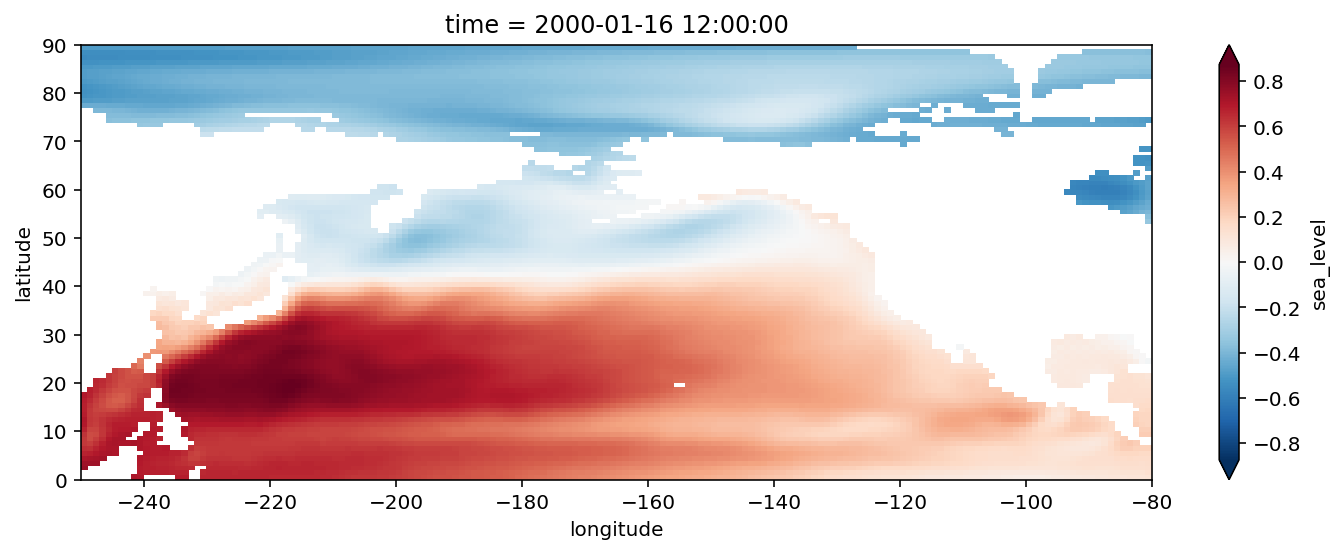

In [15]:
ssh_1_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                  'latitude': slice(0, 90)}).plot(figsize=(12, 4),
                                                                  extend='both');

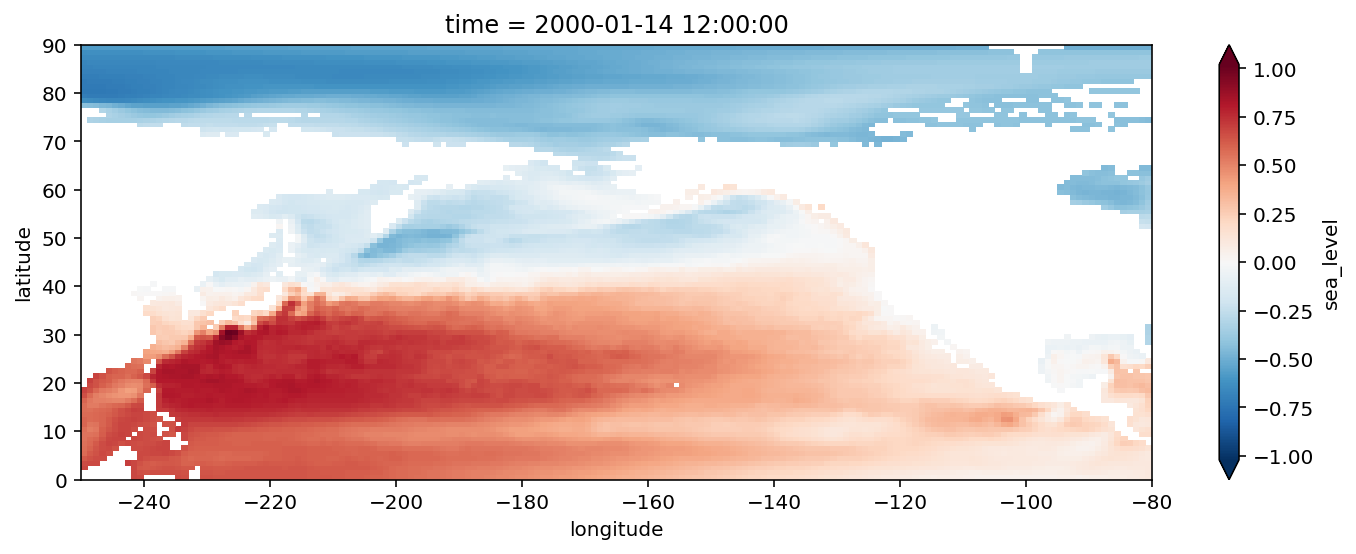

In [16]:
ssh_025_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                  'latitude': slice(0, 90)}).plot(figsize=(12, 4),
                                                                  extend='both');

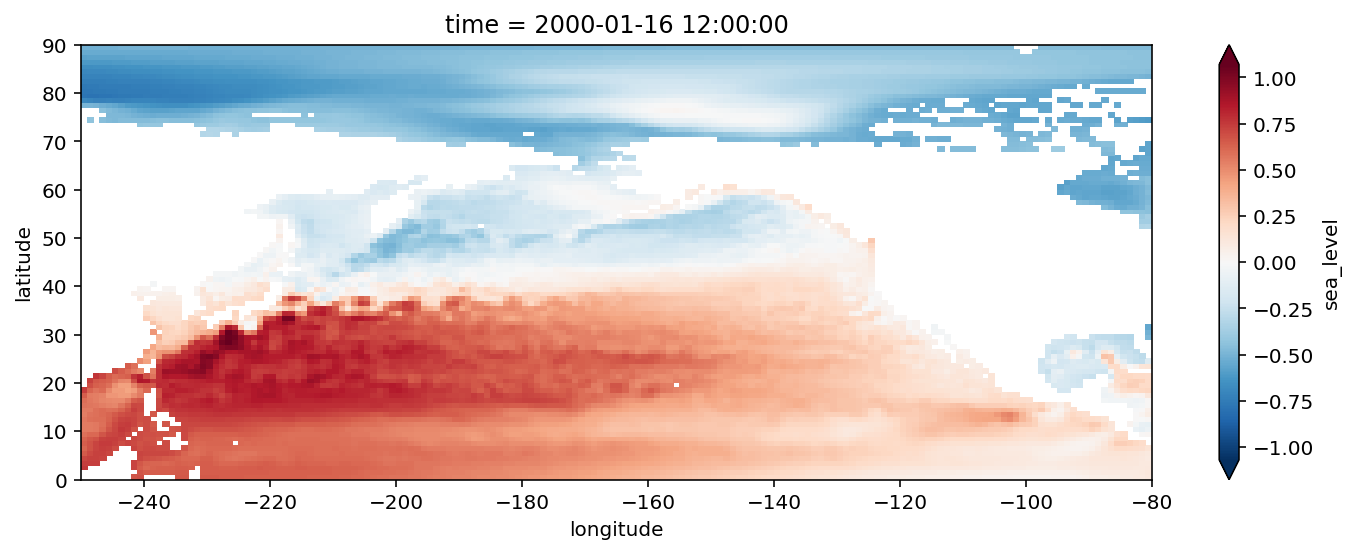

In [17]:
ssh_010_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                  'latitude': slice(0, 90)}).plot(figsize=(12, 4),
                                                                  extend='both');

Another thing we can do now that we have everything on the same grid is to compute difference between fields at different resolutions.

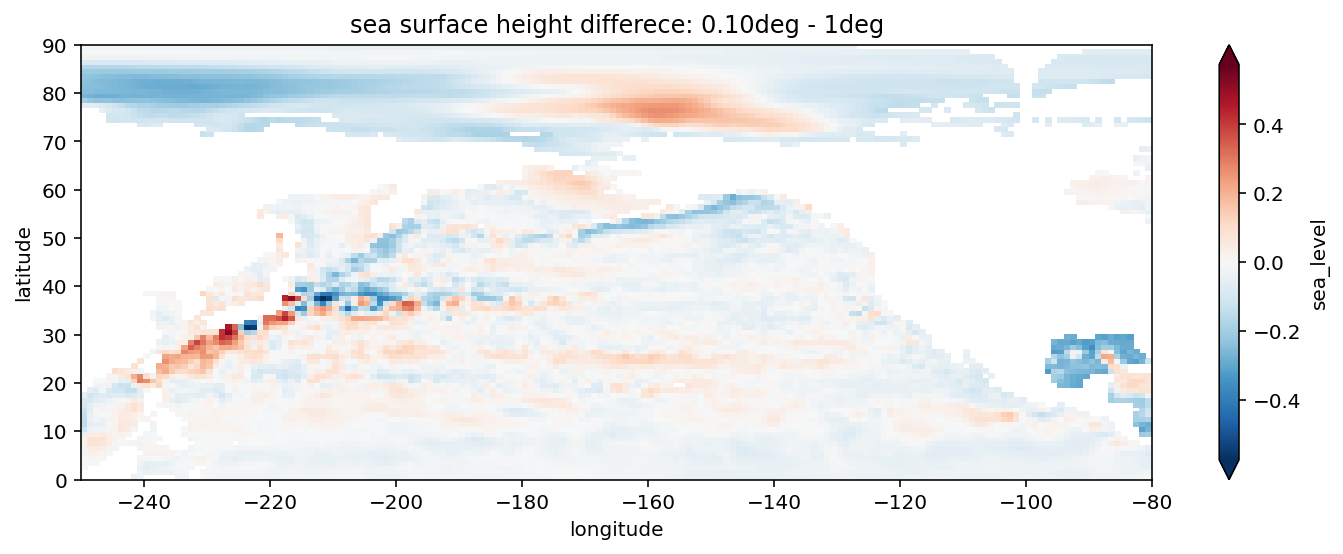

In [18]:
(ssh_010_regridded - ssh_1_regridded).isel(time=0).sel({'longitude': slice(-250, -80),
                                  'latitude': slice(0, 90)}).plot(figsize=(12, 4),
                                                                  extend='both');
plt.title('sea surface height differece: 0.10deg - 1deg');